<a href="https://colab.research.google.com/github/asiabak/Licencjat-modele/blob/main/SVM_z_wykresami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gensim scikit-learn nltk pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
# First, verify GPU is available in Colab
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Install necessary libraries if not already available
# !pip install gensim scikit-learn nltk pandas

import urllib.request
import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from gensim.models import FastText
import tensorflow as tf
import time
import os

# Use GPU for tensor operations
with tf.device('/GPU:0'):
    # Download NLTK data if needed
    nltk.download('punkt_tab')

    # Set up paths for KGR10 FastText model
    model_url = "https://huggingface.co/clarin-pl/fasttext-kgr10/resolve/main/kgr10.plain.skipgram.dim100.neg10.bin"
    model_path = "kgr10.plain.skipgram.dim100.neg10.bin"

    # Download model if it doesn't exist
    if not os.path.exists(model_path):
        print(f"Downloading KGR10 FastText model from {model_url}...")
        urllib.request.urlretrieve(model_url, model_path)
        print("Download complete!")
    else:
        print(f"Using existing model at {model_path}")

    # Load the FastText model
    print("Loading KGR10 FastText model...")
    model = FastText.load_fasttext_format(model_path)
    print(f"Model loaded! Vector size: {model.vector_size}")

    # Load datasets
    print("Loading datasets...")
    reviews = pd.read_csv("/content/filmweb_6500_obrobiony.csv")
    reviews_with_idioms = pd.read_csv('/content/filmweb_6500_i_idiomy2')
    print(f"Loaded {len(reviews)} reviews and {len(reviews_with_idioms)} reviews with idioms")

    # Text preprocessing
    def preprocess_text(text):
        # Handle NaN values
        if isinstance(text, float) and np.isnan(text):
            return ""

        text = str(text).lower()
        text = re.sub(r'[^\w\s]', '', text)
        words = text.split()
        return ' '.join(words)

    # Apply text preprocessing
    print("Preprocessing text...")
    reviews['review_processed'] = reviews['review'].apply(preprocess_text)
    reviews_with_idioms['review_processed'] = reviews_with_idioms['review'].apply(preprocess_text)

    # GPU-accelerated vectorization with TensorFlow
    def vectorize_review_batch(texts, model):
        # Function to get embeddings for one text
        def get_embeddings(text):
            if not text:  # Handle empty strings
                return np.zeros(model.vector_size)

            words = word_tokenize(text.lower())
            word_vectors = []
            for word in words:
                try:
                    # Get vector for the word
                    word_vectors.append(model.wv[word])
                except KeyError:
                    # Skip words not in vocabulary
                    continue

            if word_vectors:
                # Convert to tensor and compute mean
                vectors_tensor = tf.convert_to_tensor(word_vectors, dtype=tf.float32)
                return tf.reduce_mean(vectors_tensor, axis=0).numpy()
            else:
                return np.zeros(model.vector_size)

        # Process each text in the batch
        return [get_embeddings(text) for text in texts]

    # Process reviews in batches to utilize GPU efficiently
    def process_in_batches(df, batch_size=128):
        vectors = []
        start_time = time.time()

        for i in range(0, len(df), batch_size):
            batch_texts = df['review_processed'].iloc[i:i+batch_size].values
            batch_vectors = vectorize_review_batch(batch_texts, model)
            vectors.extend(batch_vectors)

            # Print progress
            if (i+batch_size) % 1000 == 0 or i+batch_size >= len(df):
                elapsed = time.time() - start_time
                print(f"Processed {i+len(batch_texts)}/{len(df)} reviews in {elapsed:.2f} seconds")

        return vectors

    # Create vectors with GPU acceleration
    print("Vectorizing reviews using GPU...")
    reviews_vectors = process_in_batches(reviews)
    reviews_with_idioms_vectors = process_in_batches(reviews_with_idioms)

    # Store vectors in the dataframes
    reviews['vector'] = reviews_vectors
    reviews_with_idioms['vector'] = reviews_with_idioms_vectors

# Prepare data for training (back on CPU for scikit-learn)
print("Preparing data for SVM training...")
X = np.vstack(reviews['vector'].values)
y = reviews['sentiment'].values
X2 = np.vstack(reviews_with_idioms['vector'].values)
y2 = reviews_with_idioms['sentiment'].values


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Download complete!
Loading KGR10 FastText model...


<ipython-input-1-d13e91421915>:41: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  model = FastText.load_fasttext_format(model_path)


Model loaded! Vector size: 100
Loading datasets...
Loaded 6503 reviews and 7003 reviews with idioms
Preprocessing text...
Vectorizing reviews using GPU...
Processed 6503/6503 reviews in 58.74 seconds
Processed 7003/7003 reviews in 58.83 seconds
Preparing data for SVM training...


In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=None, random_state=12)

# Train model on reviews only
print("Training SVM on reviews dataset...")
start_time = time.time()
model_svc = SVC(kernel='poly')
model_svc.fit(X_train, y_train)
print(f"SVM training completed in {time.time() - start_time:.2f} seconds")

# Predict and evaluate
y_pred = model_svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for model trained on reviews only: {accuracy}")

# Train model on reviews + idioms
print("Training SVM on reviews + idioms dataset...")
start_time = time.time()
model_svc_idioms = SVC(kernel='poly')
model_svc_idioms.fit(X2_train, y2_train)
print(f"SVM training completed in {time.time() - start_time:.2f} seconds")

# Predict and evaluate
y2_pred = model_svc_idioms.predict(X_test)
accuracy2 = accuracy_score(y_test, y2_pred)
print(f"Accuracy for model trained on reviews + idioms: {accuracy2}")

# Compare model performance
print("\nModel Performance Comparison:")
print(f"Reviews Only:        {accuracy:.4f}")
print(f"Reviews with Idioms: {accuracy2:.4f}")
print(f"Improvement:         {(accuracy2-accuracy)*100:.2f}%")

# Save models if needed
import joblib
joblib.dump(model_svc, 'svm_model_reviews_kgr10.pkl')
joblib.dump(model_svc_idioms, 'svm_model_reviews_idioms_kgr10.pkl')

Training SVM on reviews dataset...
SVM training completed in 0.71 seconds
Accuracy for model trained on reviews only: 0.5556978233034571
Training SVM on reviews + idioms dataset...
SVM training completed in 0.80 seconds
Accuracy for model trained on reviews + idioms: 0.5224071702944942

Model Performance Comparison:
Reviews Only:        0.5557
Reviews with Idioms: 0.5224
Improvement:         -3.33%


['svm_model_reviews_idioms_kgr10.pkl']


Training SVM (kernel=linear) on reviews only...
Done in 2.96s, Accuracy: 0.5772
Training SVM (kernel=linear) on reviews + idioms...
Done in 3.17s, Accuracy: 0.5803

Training SVM (kernel=poly) on reviews only...
Done in 2.08s, Accuracy: 0.5757
Training SVM (kernel=poly) on reviews + idioms...
Done in 2.73s, Accuracy: 0.5739

Training SVM (kernel=rbf) on reviews only...
Done in 2.94s, Accuracy: 0.5673
Training SVM (kernel=rbf) on reviews + idioms...
Done in 4.35s, Accuracy: 0.5696


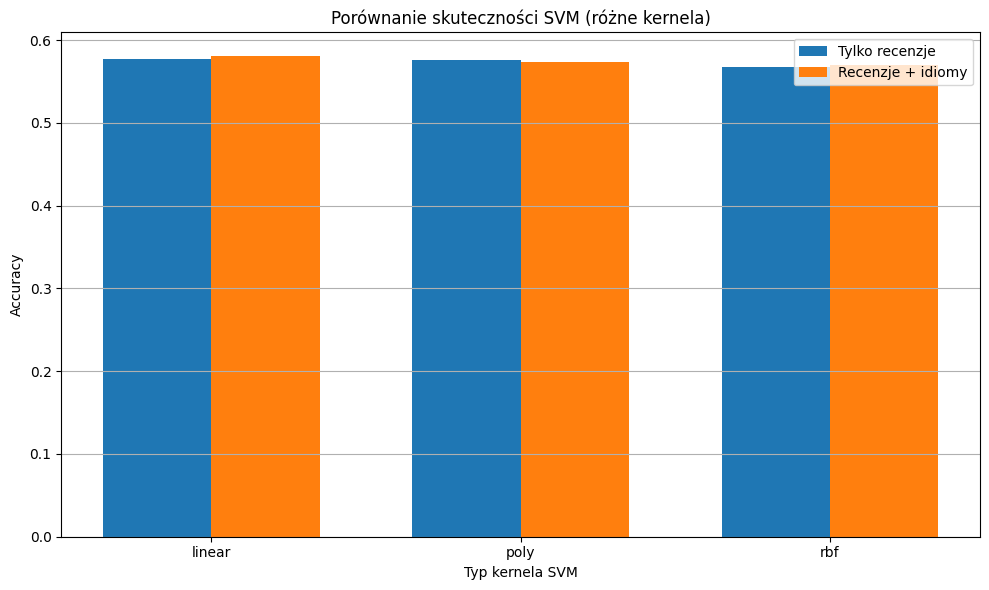

In [2]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=12)

# Lista kernelów do przetestowania
kernels = ['linear', 'poly', 'rbf']

# Miejsce na accuracy
acc_reviews = []
acc_reviews_idioms = []

# Trenowanie i zbieranie wyników
for kernel in kernels:
    print(f"\nTraining SVM (kernel={kernel}) on reviews only...")
    model = SVC(kernel=kernel)
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_reviews.append(acc)
    print(f"Done in {time.time() - start:.2f}s, Accuracy: {acc:.4f}")

    print(f"Training SVM (kernel={kernel}) on reviews + idioms...")
    model2 = SVC(kernel=kernel)
    start = time.time()
    model2.fit(X2_train, y2_train)
    y2_pred = model2.predict(X2_test)
    acc2 = accuracy_score(y2_test, y2_pred)
    acc_reviews_idioms.append(acc2)
    print(f"Done in {time.time() - start:.2f}s, Accuracy: {acc2:.4f}")

# Wykres porównawczy
x = np.arange(len(kernels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
bars1 = ax.bar(x - width/2, acc_reviews, width, label='Tylko recenzje')
bars2 = ax.bar(x + width/2, acc_reviews_idioms, width, label='Recenzje + idiomy')

ax.set_xlabel('Typ kernela SVM')
ax.set_ylabel('Accuracy')
ax.set_title('Porównanie skuteczności SVM (różne kernela)')
ax.set_xticks(x)
ax.set_xticklabels(kernels)
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()
